Primero voy a intentar hacer un pipeline ordenado.

Cargo las funciones de descarga de imágenes que voy a utilizar luego

In [ ]:
import pandas as pd
import numpy as np
import os

from tqdm import tqdm
from skimage import io
from typing import Optional, Union
import cv2
import urllib.request
from sklearn.model_selection import train_test_split

def download_images(paths: list,
                    canvas: tuple = (128, 128),
                    nb_channels: int = 3,
                    max_imgs: Optional[int] = None
                    ) -> tuple:
    n_images = len(paths) if not max_imgs else max_imgs
    images = np.zeros((n_images, canvas[0], canvas[1], nb_channels), dtype=np.uint8)
    downloaded_idxs = []

    for i_img, url in enumerate(tqdm(paths, total=n_images)):
        if i_img >= n_images:
            break
        try:
            img = io.imread(url)
            img = cv2.resize(img, (canvas[0], canvas[1]))
            downloaded_idxs.append(i_img)
            images[i_img] = img
        except (IOError, ValueError) as e:  # Unavailable url / conversion error
            pass
    return images[downloaded_idxs], downloaded_idxs



Descargo y trabajo un poco el dataset de airbnb

In [ ]:
#descargo el dataset
!wget -O "airbnb-listings.csv" "https://public.opendatasoft.com/explore/dataset/airbnb-listings/download/?format=csv&disjunctive.host_verifications=true&disjunctive.amenities=true&disjunctive.features=true&refine.country=Spain&q=Madrid&timezone=Europe/London&use_labels_for_header=true&csv_separator=%3B"

# Cargo el dataset de airbnb.CSV
df = pd.read_csv("airbnb-listings.csv", sep = ';')

# Filtro filas sin Thumbnail Url o Precio
df = df.dropna(subset=['Thumbnail Url', 'Price'])



--2024-04-06 15:30:33--  https://public.opendatasoft.com/explore/dataset/airbnb-listings/download/?format=csv&disjunctive.host_verifications=true&disjunctive.amenities=true&disjunctive.features=true&refine.country=Spain&q=Madrid&timezone=Europe/London&use_labels_for_header=true&csv_separator=%3B
Resolving public.opendatasoft.com (public.opendatasoft.com)... 34.248.20.69, 34.249.199.226
Connecting to public.opendatasoft.com (public.opendatasoft.com)|34.248.20.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/csv]
Saving to: ‘airbnb-listings.csv’

airbnb-listings.csv     [               <=>  ]  52.85M  2.91MB/s    in 19s     

2024-04-06 15:30:54 (2.84 MB/s) - ‘airbnb-listings.csv’ saved [55414009]



In [ ]:
# Descargo imágenes

downloaded_images, _ = download_images(df['Thumbnail Url'], max_imgs=10000)

# Elimino columnas innecesarias después de descargar imágenes, aquí quizás pude haber guardado un dataset con los precios y las imágenes pero preferí hacerlo más adelante
features = ['Price', 'Property Type', 'Room Type', 'Cancellation Policy', 'Accommodates',
         'Bathrooms', 'Bedrooms', 'Beds', 'Guests Included', 'Extra People',
         'Minimum Nights', 'Maximum Nights', 'Number of Reviews', 'Host Total Listings Count']
df = df[features]

print((df[features]).dtypes) # miro un poco cómo es el dataset

100%|██████████| 10000/10000 [1:55:49<00:00,  1.44it/s]


Price                        float64
Property Type                 object
Room Type                     object
Cancellation Policy           object
Accommodates                   int64
Bathrooms                    float64
Bedrooms                     float64
Beds                         float64
Guests Included                int64
Extra People                   int64
Minimum Nights                 int64
Maximum Nights                 int64
Number of Reviews              int64
Host Total Listings Count    float64
dtype: object


In [4]:
# Divido en train/val/test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)  # 60-70% train, resto validation

print("El conjunto de entrenamiento tiene dimensiones: ", train_df.shape)
print("El conjunto de validación tiene dimensiones: ",val_df.shape)
print("El conjunto de test tiene dimensiones: ", test_df.shape)


El conjunto de entrenamiento tiene dimensiones:  (6771, 14)
El conjunto de validación tiene dimensiones:  (2257, 14)
El conjunto de test tiene dimensiones:  (2257, 14)


Normalizo

In [5]:
# Quiero ver valores nulos que puedan darme error al preprocesar
print(train_df.isnull().sum())


Price                         0
Property Type                 0
Room Type                     0
Cancellation Policy           0
Accommodates                  0
Bathrooms                    22
Bedrooms                      8
Beds                         21
Guests Included               0
Extra People                  0
Minimum Nights                0
Maximum Nights                0
Number of Reviews             0
Host Total Listings Count     2
dtype: int64


Como he visto que tengo valores faltantes en Baños, habitaciones y el total de hospedados los voy a rellenar con su media, intentando no contaminar mis datos de test ni validation

In [6]:
from sklearn.impute import SimpleImputer

# Voy a rellenar esos espacios nulos con la media de cada columna
imputer = SimpleImputer(strategy='mean')

# Lo aplico a cada set por separado para que no se contamine
train_df[['Bathrooms', 'Bedrooms', 'Beds', 'Host Total Listings Count']] = \
    imputer.fit_transform(train_df[['Bathrooms', 'Bedrooms', 'Beds', 'Host Total Listings Count']])


test_df[['Bathrooms', 'Bedrooms', 'Beds', 'Host Total Listings Count']] = \
    imputer.fit_transform(test_df[['Bathrooms', 'Bedrooms', 'Beds', 'Host Total Listings Count']])

val_df[['Bathrooms', 'Bedrooms', 'Beds', 'Host Total Listings Count']] = \
    imputer.fit_transform(val_df[['Bathrooms', 'Bedrooms', 'Beds', 'Host Total Listings Count']])

In [7]:
# Compruebo que se haya hecho correctamente
print(train_df.isnull().sum())

Price                        0
Property Type                0
Room Type                    0
Cancellation Policy          0
Accommodates                 0
Bathrooms                    0
Bedrooms                     0
Beds                         0
Guests Included              0
Extra People                 0
Minimum Nights               0
Maximum Nights               0
Number of Reviews            0
Host Total Listings Count    0
dtype: int64


Ahora voy a hacer el preprocesado de mis datos utlizando onehot encoding

In [8]:

from sklearn.preprocessing import  OneHotEncoder

# Defino las transformaciones para columnas categóricas
categorical_features = ['Property Type', 'Room Type', 'Cancellation Policy']

# utilizo el OneHotEncoder
onehot_encoder = OneHotEncoder(handle_unknown='ignore')

# Lo ajusto a los datos de entrenamiento
onehot_encoder.fit(train_df[categorical_features])

# Aplico la transformación a los datos de entrenamiento, validación y prueba
train_data = onehot_encoder.transform(train_df[categorical_features])
val_data = onehot_encoder.transform(val_df[categorical_features])
test_data = onehot_encoder.transform(test_df[categorical_features])

# Para ayudarme a colocar los nombres a las nuevas columnas
# Obtengo los nombres de las nuevas características (columnas)
feature_names = onehot_encoder.get_feature_names_out(categorical_features)

# Creo un nuevo DataFrames con las características codificadas
train_encoded_df = pd.DataFrame(train_data.toarray(), columns=feature_names)
val_encoded_df = pd.DataFrame(val_data.toarray(), columns=feature_names)
test_encoded_df = pd.DataFrame(test_data.toarray(), columns=feature_names)

# Elimino las columnas categóricas originales de los DataFrames originales
train_df.drop(columns=categorical_features, inplace=True)
val_df.drop(columns=categorical_features, inplace=True)
test_df.drop(columns=categorical_features, inplace=True)

# Reseteo los índices de los DataFrames codificados
train_encoded_df.reset_index(drop=True, inplace=True)
val_encoded_df.reset_index(drop=True, inplace=True)
test_encoded_df.reset_index(drop=True, inplace=True)

# Reseteo los índices de los DataFrames originales
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

# Y ahora los voy a concatenar los DataFrames codificados con los DataFrames originales
# Así tengo mis datos con las columnas categóricas aplicadas el onehot encoding
train_df = pd.concat([train_df, train_encoded_df], axis=1)
val_df = pd.concat([val_df, val_encoded_df], axis=1)
test_df = pd.concat([test_df, test_encoded_df], axis=1)

print("El conjunto de entrenamiento tiene dimensiones: ", train_df.shape)
print("El conjunto de validación tiene dimensiones: ",val_df.shape)
print("El conjunto de test tiene dimensiones: ", test_df.shape)

El conjunto de entrenamiento tiene dimensiones:  (6771, 40)
El conjunto de validación tiene dimensiones:  (2257, 40)
El conjunto de test tiene dimensiones:  (2257, 40)


Guardo mis datasets despuñes de hacer split y las imágenes descargadas

In [9]:
train_df.to_csv("train_data.csv", index=False)
val_df.to_csv("val_data.csv", index=False)
test_df.to_csv("test_data.csv", index=False)

# Guardo las imágenes descargadas
np.save("downloaded_images.npy", downloaded_images)

In [10]:
# Ahora voy a echarle mano a las imágenes

# Cargo las imágenes descargadas

downloaded_images = np.load("downloaded_images.npy")

# Aquí hago la normalización y redimensionado
images = downloaded_images.astype("float32") / 255.
image_size = (128, 128)

# Guardo imágenes normalizadas
np.save("normalized_images.npy", images)

# Filtro el dataset original y me quedo con los indices de las filas para luego poder filtrar mis imágenes que corresponden a esas filas
df_prices = df["Price"]
filtered_df_images = df_prices.iloc[_]

# Divido en train/val/test
X_train_val, X_test_images, y_train_val, y_test_images = train_test_split(downloaded_images, filtered_df_images, test_size=0.2, random_state=42)
X_train_images, X_val_images, y_train_images, y_val_images = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

# Y las guardo
np.save("train_images.npy", X_train_images)
np.save("val_images.npy", X_val_images)
np.save("test_images.npy", X_test_images)


Voy a montar los datos en mi drive

In [ ]:
from google.colab import drive # Utilicé esta celda para poder leer mis datasets desde el drive sin tener que volver a cargar todas las casillas anteriores cuando se desconectaba el Colab
drive.mount('/content/drive')


Mounted at /content/drive


In [11]:
from google.colab import drive
drive.mount('/content/drive')

# Primero creo las carpetas en la carpeta "DL" que tengo mi Drive
!mkdir -p "/content/drive/My Drive/DL/train/"
!mkdir -p "/content/drive/My Drive/DL/validation/"
!mkdir -p "/content/drive/My Drive/DL/test/"

# Guardo
!cp train_data.csv "/content/drive/My Drive/DL/"
!cp val_data.csv "/content/drive/My Drive/DL/"
!cp test_data.csv "/content/drive/My Drive/DL/"
!cp normalized_images.npy "/content/drive/My Drive/DL/"
!cp train_images.npy "/content/drive/My Drive/DL/train/"
!cp val_images.npy "/content/drive/My Drive/DL/validation/"
!cp test_images.npy "/content/drive/My Drive/DL/test/"

Mounted at /content/drive


In [12]:
#compruebo que se haya hecho bien
!ls -lah "/content/drive/My Drive/DL/train/"
!ls -lah "/content/drive/My Drive/DL/validation/"
!ls -lah "/content/drive/My Drive/DL/test/"

total 220M
-rw------- 1 root root 220M Apr  6 17:40 train_images.npy
total 74M
-rw------- 1 root root 74M Apr  6 17:40 val_images.npy
total 74M
-rw------- 1 root root 74M Apr  6 17:40 test_images.npy


In [13]:
# Ahora voy a leerlos desde mi drive una vez ya preprocesados

train_file_path = "/content/drive/My Drive/DL/train_data.csv"
val_file_path = "/content/drive/My Drive/DL/val_data.csv"
test_file_path = "/content/drive/My Drive/DL/test_data.csv"

train_df = pd.read_csv(train_file_path)
val_df = pd.read_csv(val_file_path)
test_df = pd.read_csv(test_file_path)

In [14]:
print("El conjunto de entrenamiento tiene dimensiones: ", train_df.shape)
print("El conjunto de validación tiene dimensiones: ",val_df.shape)
print("El conjunto de test tiene dimensiones: ", test_df.shape)

El conjunto de entrenamiento tiene dimensiones:  (6771, 40)
El conjunto de validación tiene dimensiones:  (2257, 40)
El conjunto de test tiene dimensiones:  (2257, 40)


Defino una función para averiguar el mejor learning rate, epoch y batch para mi modelo aplicado a los datos tabulares

In [ ]:
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Defino lo que serán mi variable objetivo tanto en training como en validation
X_train = train_df.drop(columns=['Price'])
y_train = train_df['Price']

X_val = val_df.drop(columns=['Price'])
y_val = val_df['Price']

# Defino los hiperparámetros a probar
learning_rates = [0.001, 0.01, 0.05, 0.1]  # Elijo estos learning rates porque hacerlo con el linspace me tardaba el código demasiado
epochs = range(10, 31, 5)  # Desde 5 hasta 30, de 5 en 5
batch_sizes = range (20,101,10)

best_loss = float('inf')
best_hyperparams = {}

# Hago un bucle "for" para probar todas las combinaciones de hiperparámetros
for lr in learning_rates:
    for epoch in epochs:
        for batch_size in batch_sizes:
            # Copio mi modelo que quiero aplicar a los datos tabulares
            model = Sequential([
                Dense(64, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l2(0.001)),
                Dropout(0.3),
                Dense(1)
            ])
            model.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error')

            # Entreno el modelo con los hiperparámetros
            model.fit(X_train, y_train, epochs=epoch, batch_size=batch_size, validation_data=(X_val, y_val), verbose=1)

            # Evaluo el modelo en el conjunto de validación
            val_loss = model.evaluate(X_val, y_val)

            # Voy actualizando los mejores hiperparámetros si se encuentra una combinación mejor
            if val_loss < best_loss:
                best_loss = val_loss
                best_hyperparams = {'learning_rate': lr, 'epochs': epoch, 'batch_size': batch_size}

print("Mejores hiperparámetros:", best_hyperparams)


Se han truncado las últimas 5000 líneas del flujo de salida.
226/226 [==============================] - 1s 5ms/step - loss: 4321685504.0000 - val_loss: 25220118.0000
Epoch 15/20
226/226 [==============================] - 1s 5ms/step - loss: 20190088.0000 - val_loss: 7563083.0000
Epoch 16/20
226/226 [==============================] - 2s 7ms/step - loss: 680341696.0000 - val_loss: 15118553.0000
Epoch 17/20
226/226 [==============================] - 1s 4ms/step - loss: 486739040.0000 - val_loss: 851926.2500
Epoch 18/20
226/226 [==============================] - 1s 4ms/step - loss: 187695456.0000 - val_loss: 12075651.0000
Epoch 19/20
226/226 [==============================] - 1s 3ms/step - loss: 348432192.0000 - val_loss: 15835385.0000
Epoch 20/20
71/71 [==============================] - 0s 3ms/step - loss: 1750009.1250
Epoch 1/20
170/170 [==============================] - 2s 5ms/step - loss: 3604964.7500 - val_loss: 18640.9688
Epoch 2/20
170/170 [==============================] - 1s 4ms/s

Veo que enn principio los mejores hiperparámetros serían 0.05 para learning rate, 25 las épocas, y 30 el batch.
Ahora lo aplico a mi modelo

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Vuelvo a cargar los datos preprocesados probando otros nuevos hiperparámetros sin tener que aplicar la función anterior
X_train = train_df.drop(columns=['Price'])
y_train = train_df['Price']

X_val = val_df.drop(columns=['Price'])
y_val = val_df['Price']

# Compruebo las formas de los datos
print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)

# Defino mi modelo Dense
tabular_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(1)  # Capa de salida
])


# Compilar modelo
tabular_model.compile(optimizer=Adam(learning_rate=0.05), loss='mean_squared_error')

# Entrenamiento del modelo
tabular_model.fit(X_train, y_train, epochs=25, batch_size=30, validation_data=(X_val, y_val))

Shape of X_train: (6771, 39)
Shape of X_val: (2257, 39)
Epoch 1/25
226/226 [==============================] - 2s 4ms/step - loss: 24582.6914 - val_loss: 7600.5591
Epoch 2/25
226/226 [==============================] - 1s 3ms/step - loss: 6911.9600 - val_loss: 5025.8950
Epoch 3/25
226/226 [==============================] - 1s 3ms/step - loss: 8410.5518 - val_loss: 7390.4468
Epoch 4/25
226/226 [==============================] - 1s 3ms/step - loss: 5138.5864 - val_loss: 7545.2104
Epoch 5/25
226/226 [==============================] - 0s 2ms/step - loss: 4670.2686 - val_loss: 4378.3672
Epoch 6/25
226/226 [==============================] - 1s 2ms/step - loss: 5024.6763 - val_loss: 3901.3137
Epoch 7/25
226/226 [==============================] - 0s 2ms/step - loss: 4607.4673 - val_loss: 3653.6951
Epoch 8/25
226/226 [==============================] - 0s 2ms/step - loss: 4401.4282 - val_loss: 3517.8621
Epoch 9/25
226/226 [==============================] - 1s 2ms/step - loss: 4055.8945 - val_loss:

Probando el modelo, primero lo hice con doble capa ocultas, pero los resultados me mostraban que había demasiado sobreajuste del modelo a los datos de training, por eso opté por solo una capa oculta. Luego fui probando con el numero de neuronas y el que mejor resultados me dio fue con 64, igual procedimiento seguí para el dropout y regularizador.

Más abajo aplico sobre test y lo represento

71/71 [==============================] - 0s 1ms/step


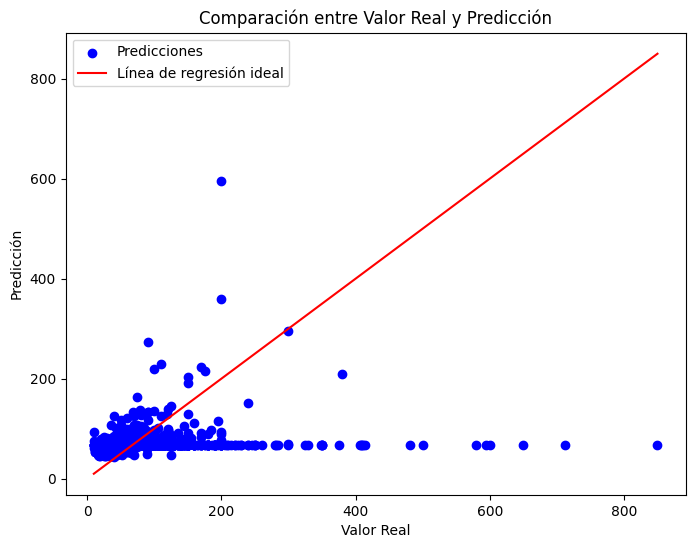

In [16]:
import matplotlib.pyplot as plt

X_test = test_df.drop(columns=['Price'])
y_test= test_df['Price']

predictions_tabular_model = tabular_model.predict(X_test)

# Represento mediante gráfico de dispersión
plt.figure(figsize=(8, 6))
plt.scatter(test_df['Price'], predictions_tabular_model, color='blue', label='Predicciones')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', label='Línea de regresión ideal')
plt.xlabel('Valor Real')
plt.ylabel('Predicción')
plt.title('Comparación entre Valor Real y Predicción')
plt.legend()
plt.show()

## Procesado de las imágenes

In [17]:
# Voy a cargar los datos de las imágenes normalizadas y guardadas en el drive

train_images_path = "/content/drive/My Drive/DL/train/train_images.npy"
val_images_path = "/content/drive/My Drive/DL/validation/val_images.npy"
test_images_path = "/content/drive/My Drive/DL/test/test_images.npy"

# Cargo
X_train_images = np.load(train_images_path)
X_val_images = np.load(val_images_path)
X_test_images = np.load(test_images_path)

# Verifico las dimensiones de las imágenes cargadas
print("Dimensiones de las imágenes de entrenamiento:", X_train_images.shape)
print("Dimensiones de las imágenes de validación:", X_val_images.shape)
print("Dimensiones de las imágenes de prueba:", X_test_images.shape)

Dimensiones de las imágenes de entrenamiento: (4680, 128, 128, 3)
Dimensiones de las imágenes de validación: (1560, 128, 128, 3)
Dimensiones de las imágenes de prueba: (1560, 128, 128, 3)


In [ ]:
# Aquí debería aplicar un GridSearch para ver los valores de learning rate y epoch adecuados, pero con los códigos anteriores ya tarda bastante y hasta eso el servidor se ha desconectado
# y tendría que volver a empezar


Elegí MobileNetV2 porque MobileNetV2 puede manejar eficientemente imágenes de diferentes tamaños sin sacrificar demasiada precisión, lo que lo hace adecuado para procesar las imágenes de Airbnb que pueden variar en resolución y aspecto

9406464/9406464 [==============================] - 1s 0us/step
Epoch 1/20
147/147 [==============================] - 75s 482ms/step - loss: 8531.6094 - val_loss: 8186.4614
Epoch 2/20
147/147 [==============================] - 68s 467ms/step - loss: 7845.5532 - val_loss: 7398.0898
Epoch 3/20
147/147 [==============================] - 64s 439ms/step - loss: 6998.8013 - val_loss: 6471.8110
Epoch 4/20
147/147 [==============================] - 69s 468ms/step - loss: 6081.4214 - val_loss: 5591.6050
Epoch 5/20
147/147 [==============================] - 70s 475ms/step - loss: 5327.4155 - val_loss: 4933.0898
Epoch 6/20
147/147 [==============================] - 90s 613ms/step - loss: 4836.3491 - val_loss: 4542.8833
Epoch 7/20
147/147 [==============================] - 70s 480ms/step - loss: 4601.5439 - val_loss: 4364.5449
Epoch 8/20
147/147 [==============================] - 70s 475ms/step - loss: 4413.8999 - val_loss: 4296.7578
Epoch 9/20
147/147 [==============================] - 70s 481ms/s

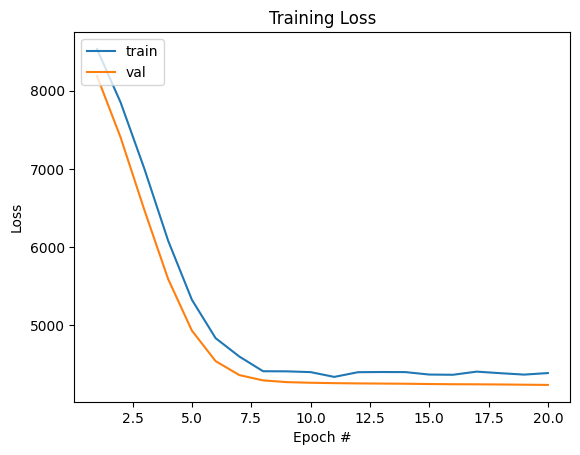

In [18]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D


# Cargo un modelo base preentrenado
base_model = MobileNetV2(input_shape=(image_size[0], image_size[1], 3), include_top=False, weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False

# Creo mi modelo
image_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1)  # Una neurona para la regresión
])

# Compilo
image_model.compile(optimizer=Adam(learning_rate=0.00001), loss='mean_squared_error')

# Entrené el modelo de imágenes varias veces y por el grafo de pérdida vi que a partir de la epoch 10 se estabilizaba
H = image_model.fit(X_train_images, y_train_images, epochs=20, validation_data=(X_val_images, y_val_images))

loss_epoch_tr = H.history['loss']
loss_epoch_val = H.history['val_loss']
#Grafo de la  pérdida
plt.plot(range(1, len(loss_epoch_tr) + 1), loss_epoch_tr)
plt.plot(range(1, len(loss_epoch_val) + 1), loss_epoch_val)
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training Loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.show()

49/49 [==============================] - 17s 329ms/step


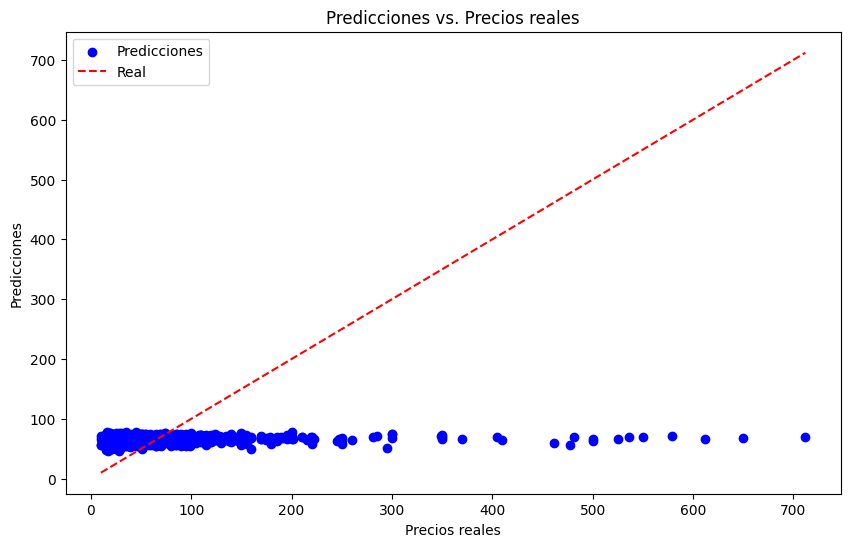

In [19]:
# Hago la predicción sobre los datos de prueba, los valores estan en datos reales
predictions_image_model = image_model.predict(X_test_images)

plt.figure(figsize=(10, 6))
plt.scatter(y_test_images, predictions_image_model, color='blue', label='Predicciones')
plt.plot([y_test_images.min(), y_test_images.max()], [y_test_images.min(), y_test_images.max()], color='red', linestyle='--', label='Real')
plt.title('Predicciones vs. Precios reales')
plt.xlabel('Precios reales')
plt.ylabel('Predicciones')
plt.legend()
plt.show()

## Fusión de los modelos con *late-fusion*

In [37]:
# Aquí me aseguro que la longitud de un modelo y del otro sea la misma

min_length = min(predictions_image_model.shape[0], predictions_tabular_model.shape[0])
predictions_images = predictions_image_model[:min_length]
predictions_tabular = predictions_tabular_model[:min_length]

# Fusiono las predicciones en un solo vector
combined_predictions = np.concatenate((predictions_images, predictions_tabular), axis=1)

# Creo un modelo para fusionar las predicciones
fusion_model = Sequential([
    Dense(64, activation='relu', input_shape=(2,)),  # Entrada: dos predicciones
    Dense(32, activation='relu'),
    Dense(1)  # Salida para la regresión final
])

# Compilo
fusion_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Entreno varias veces
fusion_model.fit(combined_predictions, y_test, epochs=10, batch_size=5, validation_split=0.2)

Epoch 1/10
250/250 [==============================] - 2s 4ms/step - loss: 3987.5425 - val_loss: 3287.6189
Epoch 2/10
250/250 [==============================] - 1s 3ms/step - loss: 3743.4124 - val_loss: 3294.4341
Epoch 3/10
250/250 [==============================] - 1s 3ms/step - loss: 3731.0569 - val_loss: 3272.5178
Epoch 4/10
250/250 [==============================] - 1s 3ms/step - loss: 3774.9124 - val_loss: 3279.9883
Epoch 5/10
250/250 [==============================] - 1s 2ms/step - loss: 3735.1306 - val_loss: 3306.2869
Epoch 6/10
250/250 [==============================] - 1s 2ms/step - loss: 3728.5273 - val_loss: 3288.3455
Epoch 7/10
250/250 [==============================] - 1s 2ms/step - loss: 3732.0405 - val_loss: 3281.0977
Epoch 8/10
250/250 [==============================] - 1s 2ms/step - loss: 3713.6619 - val_loss: 3326.9207
Epoch 9/10
250/250 [==============================] - 1s 2ms/step - loss: 3745.6077 - val_loss: 3338.3291
Epoch 10/10
250/250 [=========================

Aplico la fusión y represento con valores reales

49/49 [==============================] - 0s 1ms/step


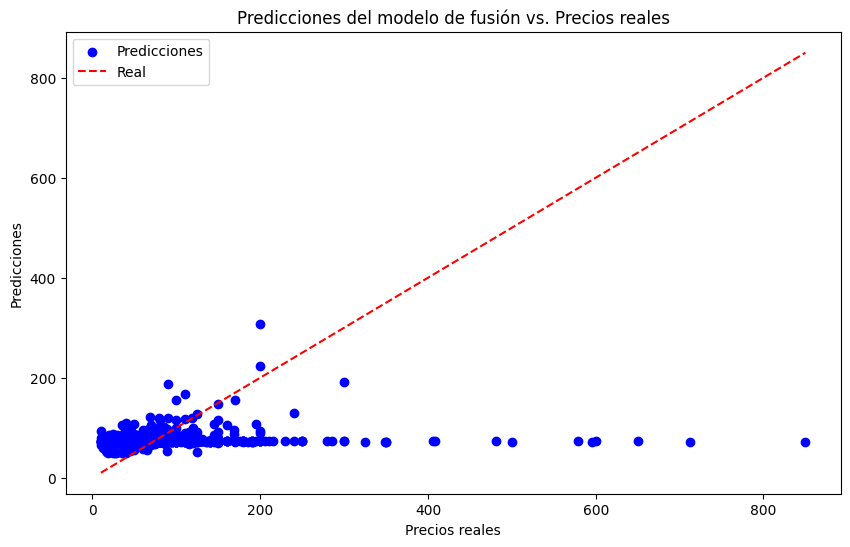

In [38]:
fusion_predictions = fusion_model.predict(combined_predictions)

plt.figure(figsize=(10, 6))
plt.scatter(y_test[:min_length], fusion_predictions, color='blue', label='Predicciones')
plt.plot([y_test[:min_length].min(), y_test[:min_length].max()], [y_test[:min_length].min(), y_test[:min_length].max()], color='red', linestyle='--', label='Real')
plt.title('Predicciones del modelo de fusión vs. Precios reales')
plt.xlabel('Precios reales')
plt.ylabel('Predicciones')
plt.legend()
plt.show()